In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")

# Wait/Travel Time Analysis Draft

## The question
This project began as an attempt to answer the question: is the bus schedule for CTA route 55 Garfield overpromising on its late-afternoon wait times or am I just unlucky? To ask the question more precisely: is 20 minutes an unreasonable amount of time to wait for an eastbound 55 Garfield bus (headed to Woodlawn Ave) at the Garfield Red Line Station at 4pm on a weekday given that I just missed the bus? I answer this question in this notebook. I also determine the expected travel time from the Garfield Red Line Station to Woodlawn Ave at 4pm on a weekday.

Note: I specifically ask about the wait times of buses not just departing from the Red Line, but also *heading to* Woodlawn. When analyzing bus headways and wait times, it is important to specify both an origin stop and a destination stop. Consider the following example. Route 55 Garfield makes trips throughout the daytime from the Museum of Science & Industry to Midway Airport and vice versa. Sometimes though buses only begin and end their trips as far west as St. Louis Avenue, a full two miles east of the airport. If you live near the MSI, and you need to catch a flight out of Midway, it wouldn't matter to you if a St. Louis-bound Garfield bus left the MSI every 10 minutes or every 10 seconds. Only the wait times between Garfield buses headed to Midway matter to you. It is, therefore, critical to calculate headways and wait times with respect to both the origin and destination.

## Notes on the data
The dataset I use is derived from 55 Garfield bus positions data collected using the CTA Bus Tracker API between January 30, 2017 and April, 4, 2017, with a gap in collection between February 17 and February 28. The dataset contains the travel and wait times for all pairs of bus stops (Garfield Red Line, Stop B), where Stop B is a possibly eastbound destination stop. Travel and wait times are calculated in minutes rounded to two decimal places.

Please note, the derived wait times in this dataset are precisely the *headways* of adjacent buses (departing the Red Line heading to stop B). We can think of the headway as the worst-case waiting time: the amount of time you would have to wait for the next bus to your destination if you just missed the departing bus.

Finding the regular average wait time between buses depends on the model of passenger arrival at the bus stop. In many cases, it's safe to assume that passengers arrive at a bus stop uniformly and at random. In this model, the average wait time for a bus (departing stop A heading to stop B) is half of the average headway (i.e. average worst-case wait time) of the buses (departing stop A and heading to stop B). I will discuss the validity of this model of passenger arrival at the Red Line later in the notebook.

## Analysis
First, I load the data into a pandas `DataFrame`. The rate at which buses are dispatched and the volume of traffic on the road changes throughout the day, so we should expect travel and wait times to fluctuate in response. In order to aggregate the data in a meaningful way, I sort the data into equally sized hour-long bins (not including the rightmost edge) that correspond to the hours of the day. The bins are labelled according the value of leftmost edge. So, [0:00, 1:00) is a bin with label 0:00, and so on. **I will refer to data falling in a particular bin by its label**. For example, buses arriving at a stop any time between [0:00, 1:00) will be said to be **arriving at 0:00**.

In [3]:
garfield_red_eb = pd.read_csv("../data/processed/trips_and_waits/55/GarfieldRed_eb.csv")
garfield_red_eb["hr_bin"] = pd.cut(garfield_red_eb.decimal_time, np.linspace(0, 24, num=24+1), labels=np.linspace(0, 23, num=24), right=False)

I also limit the analysis to trips that occurred on weekdays in which the buses departed the Garfield Red Line between 3 and 6pm and arrived later at Woodlawn. **I will refer to this filtered data as trips between the Red Line and Woodlawn**.

In [4]:
filtered = garfield_red_eb[
    (garfield_red_eb.stop == "Woodlawn")
    & (garfield_red_eb.day_of_week < 5)
    & ((garfield_red_eb.decimal_time >= 15) & (garfield_red_eb.decimal_time < 18))
].copy()

In [89]:
filtered["date"] = filtered.tripid.str.split("_", expand=True)[0]

print """
    There were {} observed eastbound trips from the Garfield Red Line station to Woodlawn 
    between 3 and 6pm during the {} weekdays of the data collection period.
""".format(filtered.shape[0], len(filtered.date.unique()))


    There were 641 observed eastbound trips from the Garfield Red Line station to Woodlawn 
    between 3 and 6pm during the 37 weekdays of the data collection period.



I plot the data to get an understanding of the distribution of travel and wait times. This understanding will help me determine appropriate representative values for the typical travel and wait times during the late afternoon. I will start with the analysis of travel times, since it is simpler.

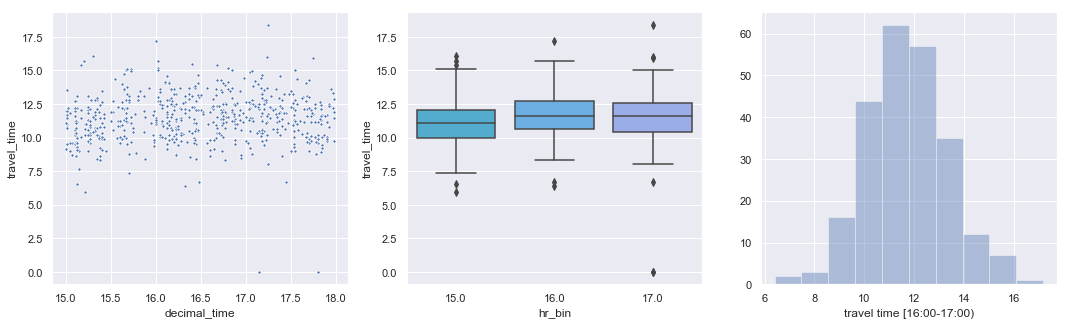

In [102]:
fig, axs = plt.subplots(ncols=3, figsize=(18,5))

sns.scatterplot(x="decimal_time", y="travel_time", data=filtered, s=10, ax=axs[0])
sns.boxplot(x="hr_bin", y="travel_time", data=filtered, ax=axs[1]).set(xlim=(14.5,17.5))
four_pm = filtered[filtered.hr_bin == 16]
sns.distplot(four_pm.travel_time, bins=10, kde=False, axlabel="travel time [16:00-17:00)", ax=axs[2])

During the late afternoon, almost all travel times fall between about 7.5 and 15 minutes with the exception of a few outliers. Over half of the travel times fall between 10 and 12.5 minutes. The median travel times at the start of and during rush hour (16:00-18:00) appear slightly longer (by 30-60 seconds) than at 15:00. Overall, the late-afternoon travel times appear normally distributed by each hour. Consequently, either the median or mean travel time at 16:00 would serve well as a representative travel time during that hour.

Notice the trip at 17:00 with travel time 0 minutes. It is likely that the bus's onboard GPS malfunctioned or lagged during the trip, causing the bus's reported location to quickly jump from one point to another.

Let's determine the value of the mean and median wait times.

         mean  median
15  11.119282   11.07
16  11.694351   11.62
17  11.516473   11.62


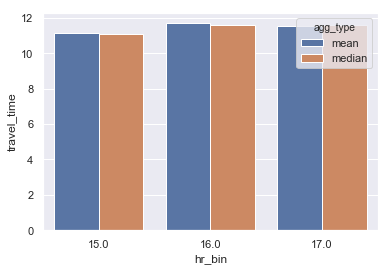

In [17]:
def build_barplot(agg_df, bin_col, obs_col):
    df = agg_df[[bin_col, obs_col]]
    df.columns = [j if j != '' else i for i,j in df.columns]
    df = df.melt(bin_col, var_name="agg_type", value_name=obs_col)
    
    sns.barplot(x=bin_col, y=obs_col, hue="agg_type", data=df)
    
aggregated = filtered.groupby(["hr_bin"]).agg(["mean", "median"]).reset_index().dropna()

print aggregated.travel_time
build_barplot(aggregated, "hr_bin", "travel_time")

Just as expected, the mean and median travel times are almost equal for each hour. I feel okay saying that one should expect a weekday trip at 16:00 from the Red Line to Woodlawn to take a little over 11.5 minutes.

Next, I'll analyze the wait times.

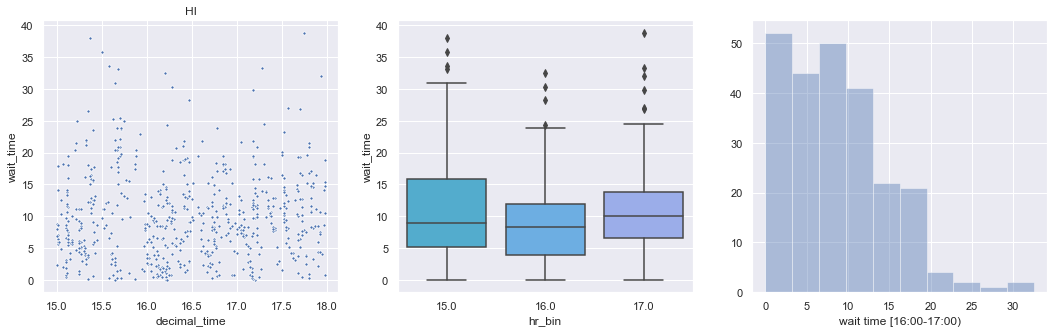

In [107]:
fig, axs = plt.subplots(ncols=3, figsize=(18,5))

sns.scatterplot(x="decimal_time", y="wait_time", data=filtered, s=10, ax=axs[0])
sns.boxplot(x="hr_bin", y="wait_time", data=filtered, ax=axs[1]).set(xlim=(14.5,17.5))
sns.distplot(four_pm.wait_time, bins=10, kde=False, axlabel="wait time [16:00-17:00)", ax=axs[2])

In [104]:
print "Histogram values: {}".format(np.histogram(four_pm.wait_time, bins=10)[0])
print "Bin edges: {}".format([float(x) for x in np.histogram_bin_edges(four_pm.wait_time, bins=10)])

Histogram values: [52 44 50 41 22 21  4  2  1  2]
Bin edges: [0.03, 3.28, 6.53, 9.78, 13.03, 16.28, 19.53, 22.78, 26.03, 29.28, 32.53]


While travel times are more or less normally distributed during each hour of the late afternoon, the wait times have a much wider spread and more extreme outliers at the high end of the distribution. Most wait times fall between 5 and 15 minutes, but some were observed to be as long as 20-30 minutes, with a couple outliers exceeding 35 minutes.

At 16:00, a 20 minute wait time would fall in the top 25% longest observed wait times. Such an observation would not be considered an outlier. Outlying wait times start around 24 minutes (Note: An outlier is defined at falling 1.5 times the inner quartile range (IQR) above the upper quartile or below the lower quartile). Because the data is not normally distributed, the mean and median wait times will show a greater discrepancy.

Let's try to come up with a representative value for the late-afternoon wait times. First, I'll compare the mean and median wait times for each hour.

         mean  median
15  10.842154    8.92
16   8.774812    8.37
17  10.438599   10.03


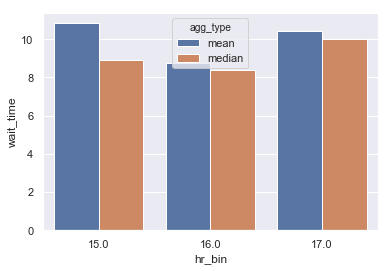

In [334]:
print aggregated.wait_time
build_barplot(aggregated, "hr_bin", "wait_time")

As expected, there's a greater discrepancy between the mean and median wait times than travel times. At 15:00, the mean wait time is almost 2 minutes longer than the median wait time, while the mean wait times are 40 seconds longer at 16:00 and 15:00. Despite the discrepancy at 16:00, the median and mean wait times are still relatively close. Is the average wait time, 8.8 minutes, representative of wait times at this hour?

Something to keep in mind is the distribution of wait times at 16:00, and in particular, the peak at 0.03-3.28 minutes. The high count of very short wait times suggests that bus bunching is likely a problem at this time on this route. There were 52 observed very short wait times at 16:00 over the course of 37 weekdays, for an average of 1.4 incidents per day. Bus bunching often translates into longer experienced wait times for riders, so it is possible that the experienced average wait time is longer than 8.8 minutes. From the perspective of passengers, a group of two buses arriving within a minute of each other every 20 minutes is not the same as two buses arriving every 10 minutes. To passengers, the former situation is experienced as longer wait times. It can be useful to average grouped arrivals (e.g. arrivals within two or three minutes of each other) into a single arrival time to determine a more realistic wait time. This more nuanced analysis requires revisions to the data processing scripts that I will not undertake now but is an approach I will consider for the future.

Instead, to get a sense of the impact of bus bunching, I examine the number of buses arriving at/departing from the Red Line at 16:00 and the distribution of the arrival/departure times.

In [105]:
four_pm.groupby("date").tripid.count().describe()

count    36.000000
mean      6.638889
std       1.312637
min       4.000000
25%       5.750000
50%       7.000000
75%       8.000000
max       8.000000
Name: tripid, dtype: float64

7 to 8 buses arrived at 16:00 for at least half of the days observed, with an average of 6.6 buses arriving each day during that hour. If bus arrivals/departures were evenly distributed, then we should see one bus arrival/departure every 9.1 minutes. Of course, the arrivals/departures are not evenly distributed, as inferred from the above wait time distribution. 

Let's now take a look at the distribution of arrival/departure times at 16:00 to see if there are any service clusters. I sort the arrival/departure times into 7 bins of roughly 8.6 minutes each.

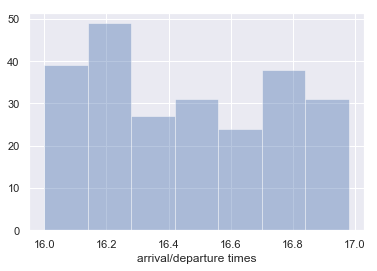

In [149]:
sns.distplot(four_pm.decimal_time, bins=7, kde=False, axlabel="arrival/departure times")

There is an arrival/departure peak at the start of the hour and a smaller peak right before the end of the hour. Also, notice the slight lull in arrivals right after 16:30. The taller peak at 8.6 minutes suggests bus bunching is more frequent toward the start of the hour. It does not seem, however, that service is dramatically clustered during any part of the hour. I believe several more month's worth of data is necessary to reach a more definitive conclusion. I feel comfortable saying that 8.8 minutes is close to a representative worst-case wait time between buses, though perhaps slightly on the low side.

Finally, a quick way to gauge the unluckiness of a 20 minute wait time in the late-afternoon is to see what proportion of wait times are shorter.

In [147]:
from scipy import stats

def percentile_summary(df, bin_col, obs_col, score):
    for _bin in df[bin_col].unique():
        percentile = stats.percentileofscore(df.loc[df[bin_col] == _bin, obs_col].values, score)
        print "At {:02.0f}:{:02.0f}, {:.1f}% of wait times are shorter than {} minutes.".format(_bin // 1, 60 * (_bin % 1), percentile, score)
        
percentile_summary(filtered, "hr_bin", "wait_time", 20)

At 15:00, 86.2% of wait times are shorter than 20 minutes.
At 16:00, 96.2% of wait times are shorter than 20 minutes.
At 17:00, 93.2% of wait times are shorter than 20 minutes.


Over 96% of wait times are shorter than 20 minutes at 16:00! In fact, recall from the distribution that over 75% of the wait times were under 12 minutes.

## Conclusion
If a passenger just misses an eastbound 55 Garfield bus at the Red Line at 16:00 on a weekday, they will wait about 8.8 minutes (or 8 minutes, 48 seconds) on average for the next bus to arrive. A 20 minute wait time is 11.2 minutes longer than the worst-case average. Over 96% of the observed worst-case wait times are shorter than 20 minutes, but such a long wait time is not an outlier. I conclude that waiting 20 minutes for the 55 Garfield bus in the given conditions is not unreasonable provided that I just missed the previous bus. It is, however, unlikely to happen. Once on the bus, the ride from the Red Line to Woodlawn takes 11.5 minutes on average. 

My question includes the stipulation that I just missed the bus, meaning that my wait time should be longer than a passenger who arrive to the bus stop at a random time. For passengers showing up to a stop uniformly at random, the average wait time is half of the average worst-case wait time, about 4.5 minutes in this scenario. A 20 minute wait time is unreasonble from the point of view of an arbitrary passenger. In reality, the situation is much more complicated. Passengers arriving to a bus stop at a train station almost definitely do not show up uniformly at random, but rather show up in accordance to train arrivals. For a more thorough wait time analysis, I need to analyze the Red Line shedule to determine when passengers are most likely to arrive at the bus stop and how it relates to bus arrivals. Additionally, this analysis would benefit from several more month's worth of observations.